## This notebook compares and visualizes the results of 2 models.

In [2]:
# Import

In [1]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import time
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123
from sklearn.decomposition import PCA
import pandas as pd

from pandas.core import base
from utils import *  # bad practice, nvm

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from dataset import NumpyDataset, TransformerEnsembleDataset, TrainSamplerMultiClass, TrainSampler, TrainSamplerMultiClassUnit
from models import AggregateFeatEnsemble, DynamicWeightEnsemble, LogisticRegression, BertClassiferHyperparams, SimpleEnsemble, FixedWeightEnsemble
from tqdm import tqdm
import time
import torch.nn.functional as F
from contrastive_utils import compute_sim_matrix, compute_target_matrix, contrastive_loss

ckpt_dir = 'exp_data'

[nltk_data] Downloading package stopwords to /home/aibo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/aibo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
# specify ids of the 2 models
model1 = "4a"
model2 = "4b" # basline model

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Load features of the 2 models

In [20]:
output_list_1 = torch.load("./exp_data/output_list_" + model1 + ".pt").cpu().numpy() 
feature_list_1 = torch.load("./exp_data/feature_list_" + model1 + ".pt").cpu().numpy()
label_list_1 = torch.load("./exp_data/label_list_" + model1 + ".pt")
output_list_2 = torch.load("./exp_data/output_list_" + model2 + ".pt").cpu().numpy()
feature_list_2 = torch.load("./exp_data/feature_list_" + model2 + ".pt").cpu().numpy()
label_list_2 = torch.load("./exp_data/label_list_" + model2 + ".pt")

truth_list_1 = []
truth_list_2 = []
for l1, l2 in zip(label_list_1, label_list_2):
    l1 = l1.cpu().numpy().astype(np.int32)
    l2 = l2.cpu().numpy().astype(np.int32)
    truth_list_1 = np.concatenate((truth_list_1, l1))
    truth_list_2 = np.concatenate((truth_list_2, l2))
truth_label_1 = truth_list_1.astype(np.int64)
truth_label_2 = truth_list_2.astype(np.int64)
pred_label_1 = np.argmax(output_list_1, axis=1)
pred_label_2 = np.argmax(output_list_2, axis=1)

In [21]:
print(len(truth_label_1))
print(len(truth_label_2))

20192
20192


### Class-Wise Accuracy

In [22]:
n_classes = 100
class_acc_dic = {} # for each class's samples, how many are correctly predicted and how many are falsely predicted
for c in range(n_classes):
    class_acc_dic[c] = {}
    class_acc_dic[c][model1] = {}
    class_acc_dic[c][model2] = {}
    class_acc_dic[c][model1]["T"] = 0
    class_acc_dic[c][model1]["F"] = 0
    class_acc_dic[c][model2]["T"] = 0
    class_acc_dic[c][model2]["F"] = 0
for (tl1, pl1, tl2, pl2) in zip(truth_label_1, pred_label_1, truth_label_2, pred_label_2):
    if tl1 == pl1:
        class_acc_dic[tl1][model1]["T"] += 1
    else:
        class_acc_dic[tl1][model1]["F"] += 1
    if tl2 == pl2:
        class_acc_dic[tl2][model2]["T"] += 1
    else:
        class_acc_dic[tl2][model2]["F"] += 1
acc_imp = {}
failed_class = []
X = []
acc1_list = []
acc2_list = []
size_list = []
total_size = 0
print("======================================")
for c in range(n_classes):
    try:
        acc1 = class_acc_dic[c][model1]["T"] / (class_acc_dic[c][model1]["T"] + class_acc_dic[c][model1]["F"])
    except:
        print(c)
        print(class_acc_dic[c][model1]["T"])
        print(class_acc_dic[c][model1]["F"])
    acc2 = class_acc_dic[c][model2]["T"] / (class_acc_dic[c][model2]["T"] + class_acc_dic[c][model2]["F"])
    size = class_acc_dic[c][model1]["T"] + class_acc_dic[c][model1]["F"]
    total_size += size
    print("class " + str(c) + " acc1: " + str(acc1) + " acc2: " + str(acc2) + " size: " + str(size)) 
    acc_imp[c] = acc1 - acc2
    if acc1 - acc2 < -0.05:
        failed_class.append((c, acc1 - acc2))
        X.append(str(c))
        acc1_list.append(acc1)
        acc2_list.append(acc2)
        size_list.append(size)
print("======================================")

print("Classes where model 1 (severely) fails to outperform model 2")
for f in failed_class:
    print(str(f[0]) + " : " + str(f[1]))
    
print("======================================")


    

class 0 acc1: 0.9565217391304348 acc2: 0.9565217391304348 size: 184
class 1 acc1: 0.87 acc2: 0.86 size: 100
class 2 acc1: 0.7413793103448276 acc2: 0.6982758620689655 size: 116
class 3 acc1: 0.7031963470319634 acc2: 0.6164383561643836 size: 219
class 4 acc1: 1.0 acc2: 1.0 size: 202
class 5 acc1: 0.6818181818181818 acc2: 0.6439393939393939 size: 132
class 6 acc1: 0.9285714285714286 acc2: 0.9285714285714286 size: 98
class 7 acc1: 0.9946091644204852 acc2: 0.9973045822102425 size: 371
class 8 acc1: 0.5050505050505051 acc2: 0.5656565656565656 size: 99
class 9 acc1: 0.46788990825688076 acc2: 0.45871559633027525 size: 109
class 10 acc1: 0.9439775910364145 acc2: 0.9299719887955182 size: 357
class 11 acc1: 1.0 acc2: 0.9971098265895953 size: 692
class 12 acc1: 0.9514563106796117 acc2: 0.970873786407767 size: 103
class 13 acc1: 0.9856115107913669 acc2: 1.0 size: 139
class 14 acc1: 0.76 acc2: 0.6828571428571428 size: 350
class 15 acc1: 1.0 acc2: 0.9781021897810219 size: 137
class 16 acc1: 0.7024793

In [23]:
decrease_sum = 0.0
for a1, a2, s in zip(acc1_list, acc2_list, size_list):
    decrease_sum += (a1 - a2) * s
print(decrease_sum / total_size)

-0.0012381141045958795


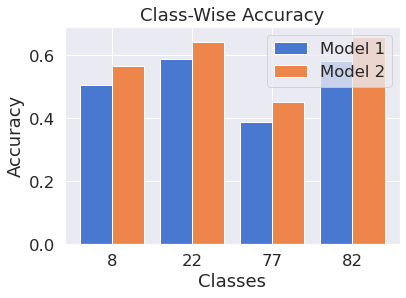

In [24]:
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, acc1_list, 0.4, label = 'Model 1')
plt.bar(X_axis + 0.2, acc2_list, 0.4, label = 'Model 2')
  
plt.xticks(X_axis, X)
plt.xlabel("Classes")
plt.ylabel("Accuracy")
plt.title("Class-Wise Accuracy")
plt.legend()
plt.show()

In [25]:
cm1 = confusion_matrix(truth_label_1, pred_label_1, normalize='all')
# f1 = sns.heatmap(cm1, annot=True)
cm2 = confusion_matrix(truth_label_2, pred_label_2, normalize='all')
# f2 = sns.heatmap(cm2, annot=True)

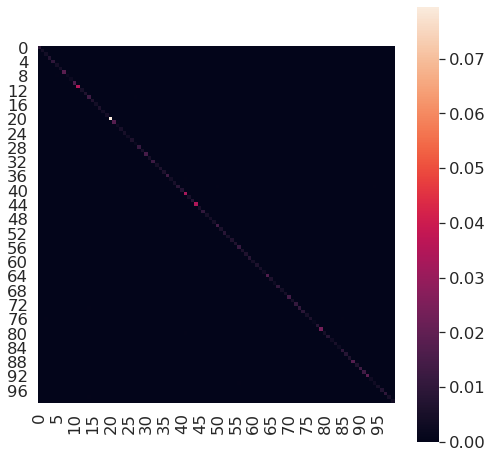

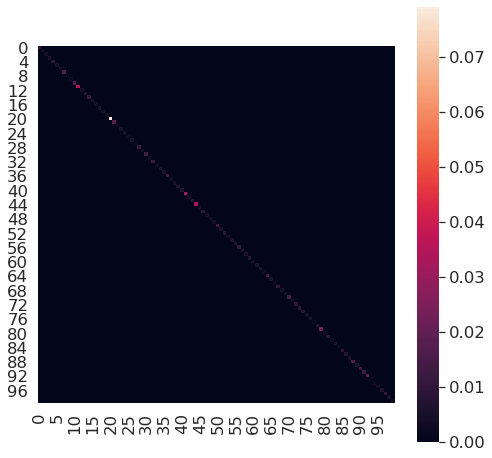

In [26]:
# with sns.axes_style("white"):
f1, ax1 = plt.subplots(figsize=(8, 8))
ax1 = sns.heatmap(cm1 ,vmax=np.max(cm1), square=True)
f2, ax2 = plt.subplots(figsize=(8, 8))
ax2 = sns.heatmap(cm2 ,vmax=np.max(cm2), square=True)

###  Visualization

In [27]:
def scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int64)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('on')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

#     for i in range(num_classes):

#         xtext, ytext = np.median(x[colors == i, :], axis=0)
#         txt = ax.text(xtext, ytext, str(i), fontsize=24)
#         txt.set_path_effects([
#             PathEffects.Stroke(linewidth=5, foreground="w"),
#             PathEffects.Normal()])
#         txts.append(txt)

    return f, ax, sc, txts

def pca_visualize(pool, colors):
    time_start = time.time()

    pca = PCA(n_components=4)
    pca_result = pca.fit_transform(pool)

    print ('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

    pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

    pca_df['pca1'] = pca_result[:,0]
    pca_df['pca2'] = pca_result[:,1]
    pca_df['pca3'] = pca_result[:,2]
    pca_df['pca4'] = pca_result[:,3]

    print ('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

    top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component
    
    scatter(top_two_comp.values,colors)
    
def tsne_visualize(pool, colors):
    RS = 123
    model_tsne = TSNE(random_state=RS).fit_transform(pool)
    # /np.max(model_tsne)
    scatter(model_tsne, colors)

In [28]:
viewed_samples = 5000 # number of points to be seen
pool1 = feature_list_1[:viewed_samples]
print(pool1.shape)
colors1 = truth_label_1[:viewed_samples]
print(len(colors1))
pool2 = feature_list_2[:viewed_samples]
print(pool2.shape)
colors2 = truth_label_2[:viewed_samples]
print(len(colors2))

(5000, 100)
5000
(5000, 100)
5000


PCA done! Time elapsed: 0.02066826820373535 seconds
Variance explained per principal component: [0.56011474 0.10880354 0.04578872 0.02749281]
PCA done! Time elapsed: 0.008386850357055664 seconds
Variance explained per principal component: [0.64909935 0.1455257  0.06671094 0.04264453]


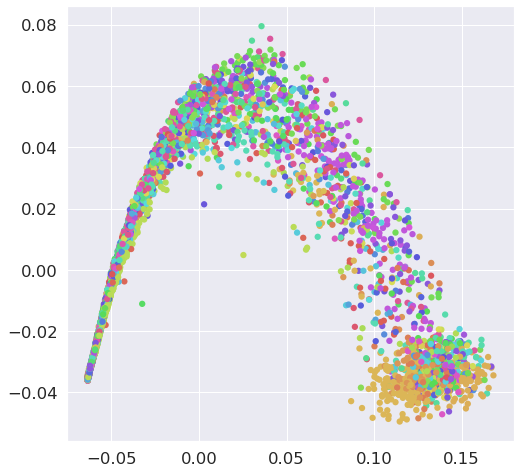

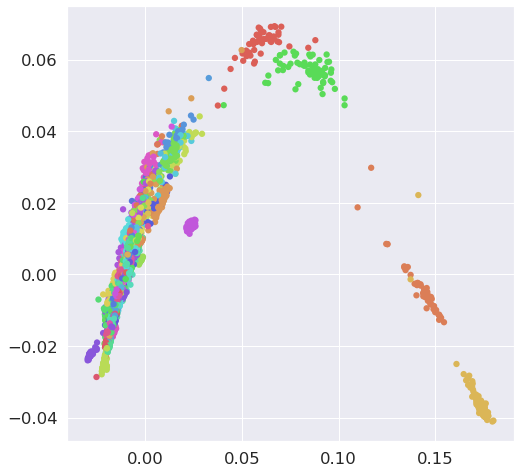

In [29]:
# sample run of pca
pca_visualize(pool1, colors1)
pca_visualize(pool2, colors2)

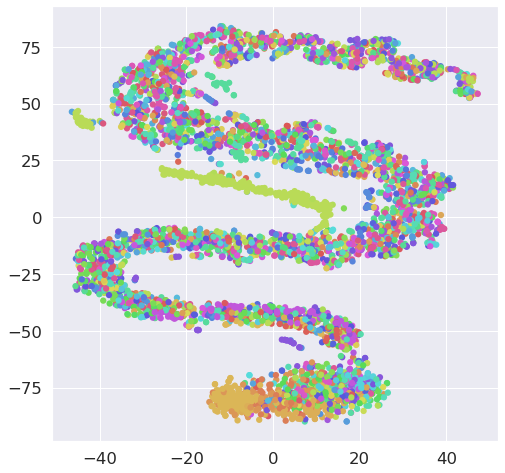

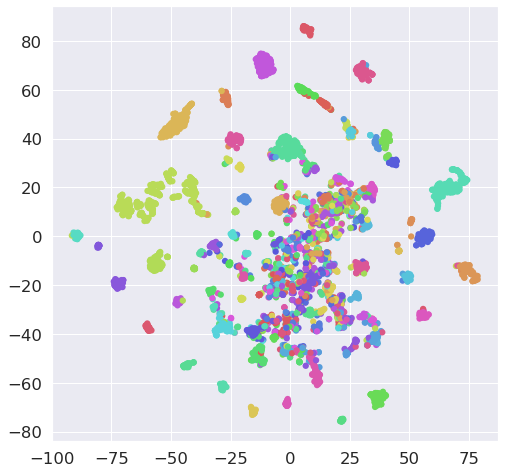

In [30]:
tsne_visualize(pool1, colors1)
tsne_visualize(pool2, colors2)